In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [34]:
data = pd.read_csv('./correlated_ground_truth_6.csv')
data['time'] = data['Frame No.']/25

In [35]:
data_filt = data.dropna()

In [87]:
data_filt['dlat'] = np.gradient(data_filt.boat_lat_rel.values,data_filt.time.values)
data_filt['dlon'] = np.gradient(data_filt.boat_lon_rel.values,data_filt.time.values)
data_filt['d2lat'] = np.gradient(data_filt.dlat.values,data_filt.time.values)
data_filt['d2lon'] = np.gradient(data_filt.dlon.values,data_filt.time.values)
data_filt['d3lat'] = np.gradient(data_filt.d2lat.values,data_filt.time.values)
data_filt['d3lon'] = np.gradient(data_filt.d2lon.values,data_filt.time.values)
data_filt['d4lat'] = np.gradient(data_filt.d3lat.values,data_filt.time.values)
data_filt['d4lon'] = np.gradient(data_filt.d3lon.values,data_filt.time.values)

D:\Conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [88]:
data_filt

,Frame No.,UTC Timestamp,estimated_time,boat_lat_rel,boat_lon_rel,time,dlat,dlon,d2lat,d2lon,d3lat,d3lon,d4lat,d4lon
103,103,19:33:59,19:34:02.48,-0.000087,0.001176,4.12,-0.000023,0.000017,-1.212815e-06,4.910374e-08,-1.362668e-06,-8.341279e-07,0.000005,-0.000005
153,153,19:34:04,19:34:04.48,-0.000133,0.001209,6.12,-0.000025,0.000017,-3.938152e-06,-1.619152e-06,7.894806e-06,-1.030510e-05,-0.001103,0.000157
172,172,19:34:04,19:34:05.24,-0.000153,0.001222,6.88,-0.000029,0.000015,4.735460e-06,-1.218624e-05,-1.149821e-03,1.553468e-04,0.001437,-0.000162
178,178,19:34:04,19:34:05.48,-0.000160,0.001226,7.12,-0.000027,0.000011,-3.592307e-04,3.792442e-05,-5.807097e-04,8.780662e-05,0.007617,-0.001031
184,184,19:34:04,19:34:05.72,-0.000166,0.001228,7.36,-0.000201,0.000033,-2.740052e-04,2.996094e-05,2.506282e-03,-3.395941e-04,0.005382,-0.000774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3472,3472,19:36:19,19:36:22.24,0.000158,0.001001,138.88,0.000014,-0.000017,1.691515e-05,-2.323660e-05,-7.605406e-06,3.329462e-06,-0.000090,0.000121
3478,3478,19:36:19,19:36:22.48,0.000162,0.000997,139.12,0.000019,-0.000024,1.320704e-05,-1.980994e-05,-3.353493e-05,3.868359e-05,-0.000070,0.000098
3484,3484,19:36:19,19:36:22.72,0.000168,0.000990,139.36,0.000020,-0.000027,8.183851e-07,-4.668480e-06,-4.107403e-05,5.013463e-05,-0.000011,0.000020
3503,3503,19:36:19,19:36:23.48,0.000172,0.000983,140.12,0.000010,-0.000017,-5.018750e-06,2.255966e-06,3.710692e-07,-8.399862e-07,0.000036,-0.000044


    The goal here should be to estimate the motion coefficients for the first few seconds of video and use these to interpolate for the KF

## Lat

In [89]:
## this LS problem is set up incorrectly
dt = data_filt.time.diff().values[1:]
lat = data_filt.boat_lat_rel.values[:-1]
dlat = data_filt.dlat.values[:-1]
d2lat = data_filt.d2lat.values[:-1]
d3lat = data_filt.d4lat.values[:-1]
y = data_filt.boat_lat_rel.diff().values[1:]
A = np.array([[sum(2*dt**6*d3lat**2), sum(2*dt**6*d3lat), sum(-2*dt**5*dlat**2)],
             [sum(2*dt**6*d3lat), sum(2*dt**6), sum(-2*dt**5*dlat**2)],
             [sum(2*dt**5*d3lat*dlat**2), sum(2*dt**5*dlat**2), sum(-2*dt**4*dlat**4)]])
b = np.array([[sum(2*dt**3*d3lat*(y-lat))],[sum(2*dt**3*(y-lat))],[sum(2*dt**2*dlat**2*(y-lat))]])

## Lon

In [90]:
## this LS problem is set up incorrectly
dt = data_filt.time.diff().values[1:]
lon = data_filt.boat_lon_rel.values[:-1]
dlon = data_filt.dlon.values[:-1]
d2lon = data_filt.d2lon.values[:-1]
d3lon = data_filt.d4lon.values[:-1]
y2 = data_filt.boat_lon_rel.diff().values[1:]
A2 = np.array([[sum(2*dt**6*d3lon**2), sum(2*dt**6*d3lon), sum(-2*dt**5*dlon**2)],
             [sum(2*dt**6*d3lon), sum(2*dt**6), sum(-2*dt**5*dlon**2)],
             [sum(2*dt**5*d3lon*dlon**2), sum(2*dt**5*dlon**2), sum(-2*dt**4*dlon**4)]])
b2 = np.array([[sum(2*dt**3*d3lon*(y2-lon))],[sum(2*dt**3*(y2-lon))],[sum(2*dt**2*dlon**2*(y2-lon))]])

In [91]:
x = np.dot(np.linalg.inv(A+A2),b+b2)

In [92]:
x

array([[-4.12860720e-01],
       [-8.54567472e-06],
       [-2.24258875e+01]])

In [72]:
np.savetxt('motion_coefficients.csv', x, delimiter = ',')

### Interpolation
#### Kalman

In [74]:
data[103:]

,Frame No.,UTC Timestamp,estimated_time,boat_lat_rel,boat_lon_rel,time
103,103,19:33:59,19:34:02.48,-0.000087,0.001176,4.12
104,104,19:33:59,19:34:02.52,NaN,NaN,4.16
105,105,19:33:59,19:34:02.56,NaN,NaN,4.20
106,106,19:33:59,19:34:02.6,NaN,NaN,4.24
107,107,19:33:59,19:34:02.64,NaN,NaN,4.28
...,...,...,...,...,...,...
3595,3595,19:36:24,19:36:27.16,NaN,NaN,143.80
3596,3596,19:36:24,19:36:27.2,NaN,NaN,143.84
3597,3597,19:36:24,19:36:27.24,NaN,NaN,143.88
3598,3598,19:36:24,19:36:27.28,NaN,NaN,143.92


In [84]:
class GPSFilter:
    #Filter for ground truth gps data interpolation
    def __init__(self, initial_estimate, motion_coeff_path, rate = 25):
        self.dt = 1/rate
        dt = 1/rate
        self.ABC = np.genfromtxt(motion_coeff_path, delimiter=',')
        A = self.ABC[0]
        B = self.ABC[1]
        C = self.ABC[2]
        a = 6*A
        b = 6*B
        g = 2*C
        self.err_est = [0, 0]
        self.err_mea = [0, 0]
        self.est = [initial_estimate, None]
        self.KG = .5
        self.system = np.array([[],
                               [],
                               []])
        
    def update(self, mea = None):
        pass
    
    def calc_estimate(self, x):
        pass
        
    def calc_kal_gain(self):
        return self.err_est/(self.err_est + self.err_mea)
    
    def calc_err(self):
        pass
        

In [85]:
filt = GPSFilter(2,'./motion_coefficients.csv')

#### Linear

In [96]:
lin_lat = np.interp(data.time.values,data_filt.time.values,data_filt.boat_lat_rel.values)
lin_lon = np.interp(data.time.values,data_filt.time.values,data_filt.boat_lon_rel.values)

In [105]:
data['lat_lin'] = lin_lat
data['lon_lin'] = lin_lon

In [106]:
data

,Frame No.,UTC Timestamp,estimated_time,boat_lat_rel,boat_lon_rel,time,lat_lin,lon_lin
0,0,19:33:54,19:33:58.36,NaN,NaN,0.00,-0.000087,0.001176
1,1,19:33:54,19:33:58.4,NaN,NaN,0.04,-0.000087,0.001176
2,2,19:33:54,19:33:58.44,NaN,NaN,0.08,-0.000087,0.001176
3,3,19:33:54,19:33:58.48,NaN,NaN,0.12,-0.000087,0.001176
4,4,19:33:54,19:33:58.52,NaN,NaN,0.16,-0.000087,0.001176
...,...,...,...,...,...,...,...,...
3595,3595,19:36:24,19:36:27.16,NaN,NaN,143.80,0.000188,0.000955
3596,3596,19:36:24,19:36:27.2,NaN,NaN,143.84,0.000188,0.000955
3597,3597,19:36:24,19:36:27.24,NaN,NaN,143.88,0.000188,0.000955
3598,3598,19:36:24,19:36:27.28,NaN,NaN,143.92,0.000188,0.000955


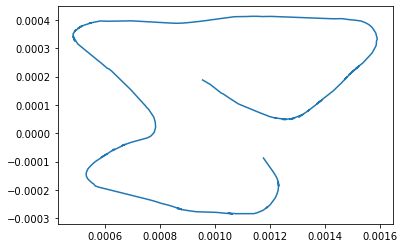

In [107]:
plt.plot(lin_lon,lin_lat)

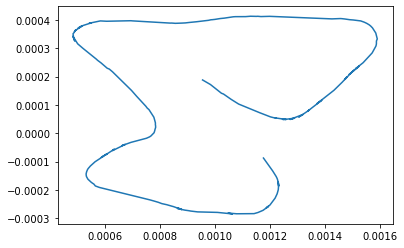

In [109]:
plt.plot(data_filt.boat_lon_rel,data_filt.boat_lat_rel)

In [111]:
data

,Frame No.,UTC Timestamp,estimated_time,boat_lat_rel,boat_lon_rel,time,lat_lin,lon_lin
0,0,19:33:54,19:33:58.36,NaN,NaN,0.00,-0.000087,0.001176
1,1,19:33:54,19:33:58.4,NaN,NaN,0.04,-0.000087,0.001176
2,2,19:33:54,19:33:58.44,NaN,NaN,0.08,-0.000087,0.001176
3,3,19:33:54,19:33:58.48,NaN,NaN,0.12,-0.000087,0.001176
4,4,19:33:54,19:33:58.52,NaN,NaN,0.16,-0.000087,0.001176
...,...,...,...,...,...,...,...,...
3595,3595,19:36:24,19:36:27.16,NaN,NaN,143.80,0.000188,0.000955
3596,3596,19:36:24,19:36:27.2,NaN,NaN,143.84,0.000188,0.000955
3597,3597,19:36:24,19:36:27.24,NaN,NaN,143.88,0.000188,0.000955
3598,3598,19:36:24,19:36:27.28,NaN,NaN,143.92,0.000188,0.000955
